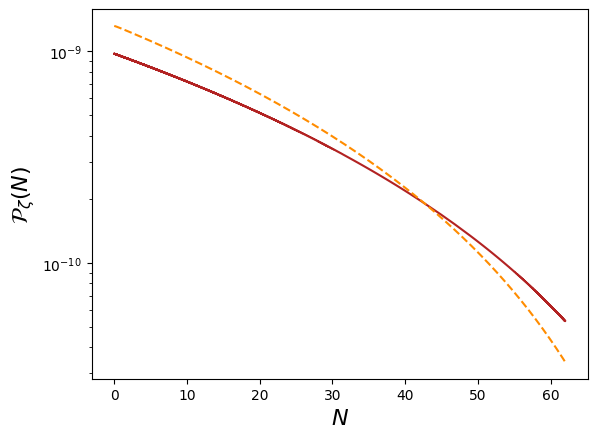

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
from numba import jit
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as tk
mpl.rcParams.update(mpl.rcParamsDefault)
from numba import jit

###################################################################
#    Input parameters for the asymmetric potential
##################################################################

lamda = 10**(-13)
beta = 10**(-12)


@jit(nopython=True)
def V(phi):
    retval = (lamda/24)*phi**4+(beta/6)*phi**3
    return retval

@jit(nopython=True)
def dV(phi):
    retval = (lamda/6)*phi**3+(beta/2)*phi**2
    return retval

@jit(nopython=True)
def ddV(phi):
    retval = (lamda/2)*phi**2+(beta)*phi

    return retval

dN = 0.001

#########################################################################################
#   The background evolution equations of inflaton solved using RK-4 method
########################################################################################
@jit(nopython=True)
def field_return(phi_in, efolds):
    N_test = efolds
    n = round(N_test/dN)
    phi = np.zeros(n)
    dphi = np.zeros(n)


    phi[0] = phi_in
    dphi[0] = -dV(phi_in)/V(phi_in)

    for i in range(n-1):
        k0 = dN*dphi[i]
        l0 = -dN*(3*dphi[i]-0.5*dphi[i]**3)-dN*(3-0.5*dphi[i]**2)*dV(phi[i])/V(phi[i])

        k1 = dN*(dphi[i]+0.5*l0)
        l1 = -dN*(3*(dphi[i]+0.5*l0)-0.5*(dphi[i]+0.5*l0)**3)-dN*(3-0.5*(dphi[i]+0.5*l0)**2)*dV(phi[i]+0.5*k0)/V(phi[i]+0.5*k0)

        k2 = dN*(dphi[i]+0.5*l1)
        l2 = -dN*(3*(dphi[i]+0.5*l1)-0.5*(dphi[i]+0.5*l1)**3)-dN*(3-0.5*(dphi[i]+0.5*l1)**2)*dV(phi[i]+0.5*k1)/V(phi[i]+0.5*k1)

        k3 = dN*(dphi[i]+l2)
        l3 = -dN*(3*(dphi[i]+l2)-0.5*(dphi[i]+l2)**3)-dN*(3-0.5*(dphi[i]+l2)**2)*dV(phi[i]+k2)/V(phi[i]+k2)

        phi[i+1] = phi[i] + (k0 + 2*k1 + 2*k2 + k3)/6
        dphi[i+1] = dphi[i] + (l0 + 2*l1 + 2*l2 + l3)/6

    return phi, dphi

N_end = 62
n_pts = round(N_end/dN)
N = np.linspace(0, N_end, n_pts)

[phi, dphi] = field_return(23.19, N_end)

eps1 = 0.5*dphi**2
eps2 = np.gradient(eps1,dN)/eps1
eta  = eps1 - 0.5*eps2
deps1 = np.gradient(eps1,dN)
deta  = np.gradient(eta,dN)
H = np.sqrt(V(phi)/(3-eps1))
a =0.217198*np.exp(N)

#########################################################################################
#     Jitted function that computes the power spectrum of curvature perturbations for all k-modes
#     The Mukhanov-Sasaki equation is solved using RK4
#########################################################################################
@jit(nopython=True)
def mode_evolve(k, N, phi, dphi):
    horizon = a*H
    Initial = 100.0*horizon
    Final = 0.01*horizon
    test_in = np.absolute(Initial-k); test_fin = np.absolute(Final-k)
    Nii = np.where(test_in == np.min(test_in))[0][0]
    Nff = np.where(test_fin == np.min(test_fin))[0][0]
    n_ = Nff - Nii + 1

####################################################################################################################
#    Bunch-Davies initial conditions
####################################################################################################################

    uk_sol = np.zeros(n_); Duk_sol = np.zeros(n_)
    vk_sol = np.zeros(n_); Dvk_sol = np.zeros(n_)

    uk_sol[0] = 1/np.sqrt(2*k); Duk_sol[0] = 0
    vk_sol[0] = 0; Dvk_sol[0] = -np.sqrt(k)/(0.01*np.sqrt(2)*k)

    for i in range(n_-1):
        f1 = -(1-eps1[Nii+i])*Duk_sol[i] - (k**2 /(a[Nii+i]*H[Nii+i])**2)*uk_sol[i] - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*uk_sol[i] + (deps1[Nii+i]-deta[Nii+i])*uk_sol[i]
        F1 = Duk_sol[i]
        f2 = -(1-eps1[Nii+i])*(Duk_sol[i]+0.5*f1*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(uk_sol[i]+0.5*F1*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(uk_sol[i]+0.5*F1*dN) + (deps1[Nii+i]-deta[Nii+i])*(uk_sol[i]+0.5*F1*dN)
        F2 = Duk_sol[i]+0.5*f1*dN
        f3 = -(1-eps1[Nii+i])*(Duk_sol[i]+0.5*f2*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(uk_sol[i]+0.5*F2*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(uk_sol[i]+0.5*F2*dN) + (deps1[Nii+i]-deta[Nii+i])*(uk_sol[i]+0.5*F2*dN)
        F3 = Duk_sol[i]+0.5*f2*dN
        f4 = -(1-eps1[Nii+i])*(Duk_sol[i]+f3*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(uk_sol[i]+F3*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(uk_sol[i]+F3*dN) + (deps1[Nii+i]-deta[Nii+i])*(uk_sol[i]+F3*dN)
        F4 = Duk_sol[i]+f3*dN

        Duk_sol[i+1] = Duk_sol[i] + dN*(f1 + 2*f2 + 2*f3 + f4)/6
        uk_sol[i+1] = uk_sol[i] + dN*(F1 + 2*F2 + 2*F3 + F4)/6

        g1 = -(1-eps1[Nii+i])*Dvk_sol[i] - (k**2 /(a[Nii+i]*H[Nii+i])**2)*vk_sol[i] - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*vk_sol[i] + (deps1[Nii+i]-deta[Nii+i])*vk_sol[i]
        G1 = Dvk_sol[i]
        g2 = -(1-eps1[Nii+i])*(Dvk_sol[i]+0.5*g1*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(vk_sol[i]+0.5*G1*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(vk_sol[i]+0.5*G1*dN) + (deps1[Nii+i]-deta[Nii+i])*(vk_sol[i]+0.5*G1*dN)
        G2 = Dvk_sol[i]+0.5*g1*dN
        g3 = -(1-eps1[Nii+i])*(Dvk_sol[i]+0.5*g2*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(vk_sol[i]+0.5*G2*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(vk_sol[i]+0.5*G2*dN) + (deps1[Nii+i]-deta[Nii+i])*(vk_sol[i]+0.5*G2*dN)
        G3 = Dvk_sol[i]+0.5*g2*dN
        g4 = -(1-eps1[Nii+i])*(Dvk_sol[i]+g3*dN) - (k**2 /(a[Nii+i]*H[Nii+i])**2)*(vk_sol[i]+G3*dN) - (1+eps1[Nii+i]-eta[Nii+i]) \
        *(eta[Nii+i]-2)*(vk_sol[i]+G3*dN) + (deps1[Nii+i]-deta[Nii+i])*(vk_sol[i]+G3*dN)
        G4 = Dvk_sol[i]+g3*dN

        Dvk_sol[i+1] = Dvk_sol[i] + dN*(g1 + 2*g2 + 2*g3 + g4)/6
        vk_sol[i+1] = vk_sol[i] + dN*(G1 + 2*G2 + 2*G3 + G4)/6

    Re_zeta = uk_sol/(np.sqrt(2*eps1[Nii:Nff+1])*a[Nii:Nff+1])
    Im_zeta = vk_sol/(np.sqrt(2*eps1[Nii:Nff+1])*a[Nii:Nff+1])
    P_zetams  = k**3 *(Re_zeta[-1]**2 + Im_zeta[-1]**2)/(2*np.pi**2)
    return P_zetams


k = 5*np.logspace(-2, 19, 62000)
P_zetams = np.zeros(62000)

for i in range(62000):
    P_zetams[i] = mode_evolve(k[i], N, phi, dphi)
    
nn_i = round(12.2/dN)
nn_f = -100
P_zeta_sr =H**2 /(8*np.pi*np.pi*eps1)


plt.plot(N, P_zetams, c='firebrick', label='Mukhanov-Sasaki')
plt.plot(N, P_zeta_sr, '--', c='darkorange', label='slow-roll')
#plt.xscale('log')
plt.legend
plt.yscale('log')
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'$\mathcal{P}_{\zeta}(N)$', fontsize=16)
plt.show()